# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

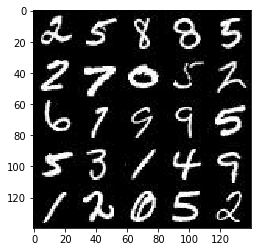

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

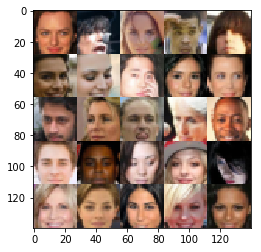

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/lucas/anaconda3/envs/myenv/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/lucas/anaconda3/envs/myenv/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/lucas/anaconda3/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/lucas/anaconda3/envs/myenv/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/lucas/anaconda3/envs/myenv/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/lucas/an

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):

       

        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(0.2 * h1, h1)

        h2 = tf.layers.conv2d(h1, 128, 3, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(0.2 * h2, h2)

        h3 = tf.layers.conv2d(h2, 256, 3, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(0.2 * h3, h3)

        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)

    return (tf.sigmoid(logits), logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    dis_real_model, dis_real_logits = discriminator(input_real, reuse=False)
    gen_model = generator(input_z, out_channel_dim)
    dis_fake_model, dis_fake_logits = discriminator(gen_model, reuse=True)

    real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_real_logits, labels=tf.ones_like(dis_real_model)))
    fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits, labels=tf.zeros_like(dis_fake_model)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits, labels=tf.ones_like(dis_fake_model)))

    dis_loss = real_loss + fake_loss

    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0779... Generator Loss: 4.6614
Epoch 1/2... Discriminator Loss: 1.4661... Generator Loss: 0.4713
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 0.5294
Epoch 1/2... Discriminator Loss: 0.1685... Generator Loss: 4.3843
Epoch 1/2... Discriminator Loss: 0.1751... Generator Loss: 3.4466
Epoch 1/2... Discriminator Loss: 0.9610... Generator Loss: 3.4051
Epoch 1/2... Discriminator Loss: 0.2047... Generator Loss: 2.2219
Epoch 1/2... Discriminator Loss: 0.2573... Generator Loss: 1.9390
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 0.6775


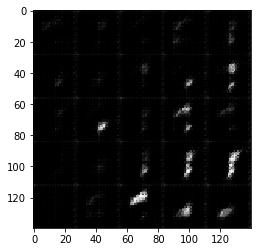

Epoch 1/2... Discriminator Loss: 0.3955... Generator Loss: 2.1999
Epoch 1/2... Discriminator Loss: 0.2794... Generator Loss: 2.1573
Epoch 1/2... Discriminator Loss: 0.3294... Generator Loss: 2.0244
Epoch 1/2... Discriminator Loss: 0.4312... Generator Loss: 2.2703
Epoch 1/2... Discriminator Loss: 0.5520... Generator Loss: 2.0925
Epoch 1/2... Discriminator Loss: 0.4644... Generator Loss: 2.1923
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 6.4009
Epoch 1/2... Discriminator Loss: 0.5745... Generator Loss: 3.4305
Epoch 1/2... Discriminator Loss: 0.5643... Generator Loss: 2.8457
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.8368


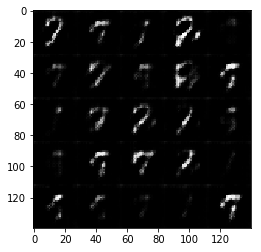

Epoch 1/2... Discriminator Loss: 0.8443... Generator Loss: 2.6100
Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 1.2782
Epoch 1/2... Discriminator Loss: 0.2310... Generator Loss: 2.3938
Epoch 1/2... Discriminator Loss: 0.3665... Generator Loss: 2.4325
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 4.3273
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 0.4906
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 2.9505
Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 0.4817
Epoch 1/2... Discriminator Loss: 0.7507... Generator Loss: 2.4214
Epoch 1/2... Discriminator Loss: 0.5742... Generator Loss: 1.7739


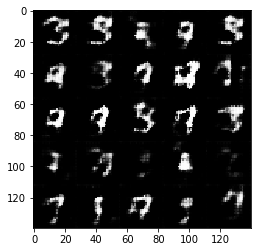

Epoch 1/2... Discriminator Loss: 0.5005... Generator Loss: 1.4357
Epoch 1/2... Discriminator Loss: 1.6082... Generator Loss: 3.6701
Epoch 1/2... Discriminator Loss: 0.7949... Generator Loss: 0.9328
Epoch 1/2... Discriminator Loss: 0.6094... Generator Loss: 2.8797
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 3.9990
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 2.8246
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.4387
Epoch 1/2... Discriminator Loss: 1.5719... Generator Loss: 2.4355
Epoch 1/2... Discriminator Loss: 1.0440... Generator Loss: 0.8787
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 1.6310


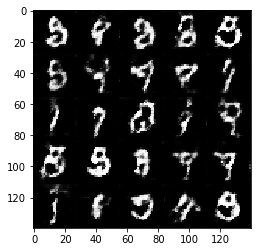

Epoch 1/2... Discriminator Loss: 0.4529... Generator Loss: 2.1924
Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 1.9703
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 0.7405... Generator Loss: 1.2015
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.6109
Epoch 1/2... Discriminator Loss: 1.3090... Generator Loss: 0.5045
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 1.2977
Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 1.8087
Epoch 1/2... Discriminator Loss: 0.6004... Generator Loss: 1.2500
Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 2.4030


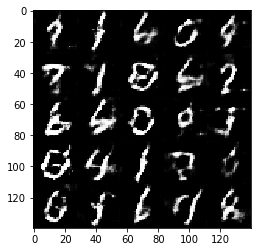

Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 1.1650
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 1.2215
Epoch 1/2... Discriminator Loss: 0.8007... Generator Loss: 2.2418
Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 2.2852
Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 2.8973
Epoch 1/2... Discriminator Loss: 0.9197... Generator Loss: 1.0758
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 1.2486
Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 1.6259
Epoch 1/2... Discriminator Loss: 0.9459... Generator Loss: 0.7438
Epoch 1/2... Discriminator Loss: 0.7245... Generator Loss: 1.7378


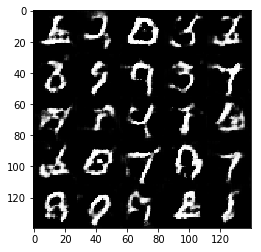

Epoch 1/2... Discriminator Loss: 0.8378... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 0.5366
Epoch 1/2... Discriminator Loss: 1.2914... Generator Loss: 0.5233
Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 1.0099
Epoch 1/2... Discriminator Loss: 1.1392... Generator Loss: 2.5533
Epoch 1/2... Discriminator Loss: 1.4317... Generator Loss: 0.3838
Epoch 1/2... Discriminator Loss: 1.0529... Generator Loss: 0.7088
Epoch 1/2... Discriminator Loss: 1.6546... Generator Loss: 0.2835
Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 1.5144
Epoch 1/2... Discriminator Loss: 0.8134... Generator Loss: 2.2360


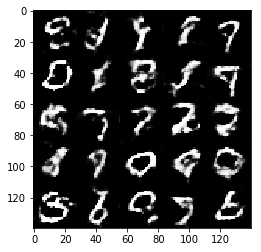

Epoch 1/2... Discriminator Loss: 0.8425... Generator Loss: 2.0615
Epoch 1/2... Discriminator Loss: 0.7849... Generator Loss: 1.1456
Epoch 1/2... Discriminator Loss: 0.8405... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 0.8994... Generator Loss: 1.4450
Epoch 1/2... Discriminator Loss: 0.8994... Generator Loss: 1.2864
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 0.5126
Epoch 1/2... Discriminator Loss: 0.8540... Generator Loss: 1.8716
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.6170
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 0.7814
Epoch 1/2... Discriminator Loss: 0.9053... Generator Loss: 0.9411


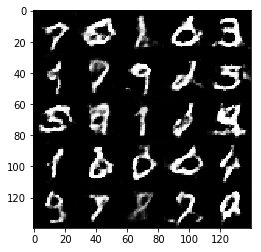

Epoch 1/2... Discriminator Loss: 0.6996... Generator Loss: 1.7240
Epoch 1/2... Discriminator Loss: 0.8516... Generator Loss: 1.5879
Epoch 1/2... Discriminator Loss: 0.6746... Generator Loss: 2.3261
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 1.7990
Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 2.1621
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 0.8337
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.3040
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 2.0130
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 0.7255
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 0.8073


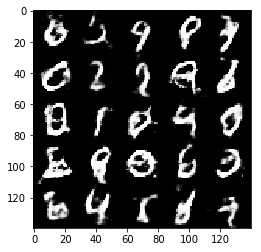

Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 1.9443
Epoch 1/2... Discriminator Loss: 0.9518... Generator Loss: 0.6801
Epoch 1/2... Discriminator Loss: 2.0199... Generator Loss: 0.1855
Epoch 1/2... Discriminator Loss: 0.8878... Generator Loss: 1.7450
Epoch 1/2... Discriminator Loss: 2.2839... Generator Loss: 3.3596
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 0.9835
Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 1.0788
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 0.7793
Epoch 1/2... Discriminator Loss: 1.7622... Generator Loss: 0.2958


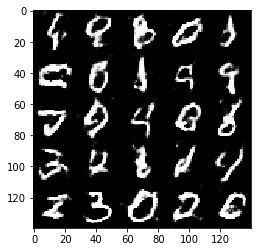

Epoch 1/2... Discriminator Loss: 0.9130... Generator Loss: 1.0270
Epoch 1/2... Discriminator Loss: 0.9524... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 2.6634... Generator Loss: 3.5280
Epoch 1/2... Discriminator Loss: 0.9261... Generator Loss: 1.4235
Epoch 1/2... Discriminator Loss: 0.6771... Generator Loss: 1.0275
Epoch 1/2... Discriminator Loss: 1.6389... Generator Loss: 0.3026
Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 0.9629
Epoch 1/2... Discriminator Loss: 0.6769... Generator Loss: 1.3352
Epoch 1/2... Discriminator Loss: 0.6836... Generator Loss: 1.0436
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 0.9782


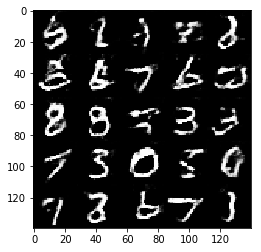

Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 1.1104
Epoch 1/2... Discriminator Loss: 0.5246... Generator Loss: 1.4911
Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 0.9550
Epoch 1/2... Discriminator Loss: 0.7606... Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 0.6282... Generator Loss: 1.2383
Epoch 1/2... Discriminator Loss: 0.7866... Generator Loss: 1.2411
Epoch 1/2... Discriminator Loss: 0.8855... Generator Loss: 0.6821
Epoch 1/2... Discriminator Loss: 1.9261... Generator Loss: 0.2981
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 1.5431


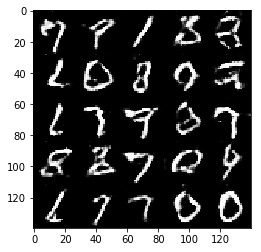

Epoch 1/2... Discriminator Loss: 0.8217... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 1.0196
Epoch 1/2... Discriminator Loss: 0.8144... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.9068... Generator Loss: 0.2586
Epoch 1/2... Discriminator Loss: 0.7691... Generator Loss: 1.0606
Epoch 1/2... Discriminator Loss: 4.5384... Generator Loss: 5.4319
Epoch 1/2... Discriminator Loss: 0.8338... Generator Loss: 1.1343
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 1.4436
Epoch 1/2... Discriminator Loss: 1.4465... Generator Loss: 0.3503


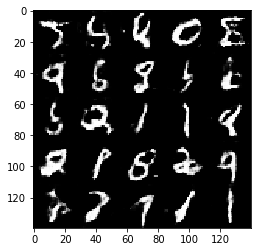

Epoch 1/2... Discriminator Loss: 0.8075... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 2.5074
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 1.5751... Generator Loss: 2.8840
Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 0.5684
Epoch 1/2... Discriminator Loss: 0.8095... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 0.7136... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 0.7837
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 0.9380


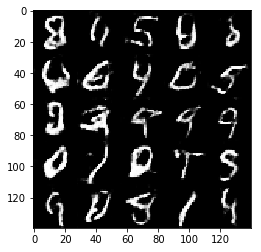

Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.4206
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.3725
Epoch 1/2... Discriminator Loss: 0.7328... Generator Loss: 1.2489
Epoch 1/2... Discriminator Loss: 0.8082... Generator Loss: 0.8774
Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 0.7051
Epoch 1/2... Discriminator Loss: 1.0654... Generator Loss: 0.9858
Epoch 1/2... Discriminator Loss: 1.2401... Generator Loss: 1.3529
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 0.4089
Epoch 1/2... Discriminator Loss: 0.5554... Generator Loss: 2.2805
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 0.4660


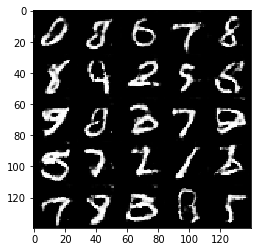

Epoch 2/2... Discriminator Loss: 0.7915... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.8682
Epoch 2/2... Discriminator Loss: 0.7758... Generator Loss: 1.2541
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 0.9711
Epoch 2/2... Discriminator Loss: 0.6801... Generator Loss: 1.0782
Epoch 2/2... Discriminator Loss: 0.6768... Generator Loss: 1.0002
Epoch 2/2... Discriminator Loss: 1.0265... Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 1.0745... Generator Loss: 0.5861
Epoch 2/2... Discriminator Loss: 0.7026... Generator Loss: 1.3260
Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 0.6066


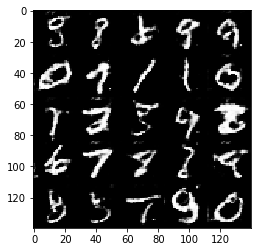

Epoch 2/2... Discriminator Loss: 0.8222... Generator Loss: 0.8666
Epoch 2/2... Discriminator Loss: 0.7587... Generator Loss: 2.1755
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 2.0364
Epoch 2/2... Discriminator Loss: 0.5639... Generator Loss: 1.7701
Epoch 2/2... Discriminator Loss: 0.7366... Generator Loss: 1.5193
Epoch 2/2... Discriminator Loss: 0.6592... Generator Loss: 1.0141
Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 0.6904... Generator Loss: 2.1729
Epoch 2/2... Discriminator Loss: 0.6896... Generator Loss: 1.5096
Epoch 2/2... Discriminator Loss: 1.2546... Generator Loss: 0.4586


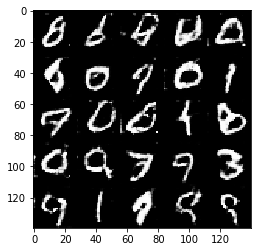

Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 1.0901
Epoch 2/2... Discriminator Loss: 0.8878... Generator Loss: 0.7446
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 1.0158
Epoch 2/2... Discriminator Loss: 0.6915... Generator Loss: 0.9797
Epoch 2/2... Discriminator Loss: 0.5109... Generator Loss: 1.4480
Epoch 2/2... Discriminator Loss: 1.6231... Generator Loss: 0.3111
Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 0.6630
Epoch 2/2... Discriminator Loss: 0.8531... Generator Loss: 0.9611
Epoch 2/2... Discriminator Loss: 0.7096... Generator Loss: 0.9896
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 1.4192


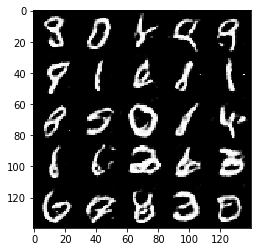

Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 0.5217
Epoch 2/2... Discriminator Loss: 0.5135... Generator Loss: 1.9666
Epoch 2/2... Discriminator Loss: 0.6282... Generator Loss: 0.9489
Epoch 2/2... Discriminator Loss: 0.5369... Generator Loss: 1.5733
Epoch 2/2... Discriminator Loss: 3.4302... Generator Loss: 6.0971
Epoch 2/2... Discriminator Loss: 1.1546... Generator Loss: 0.5945
Epoch 2/2... Discriminator Loss: 0.6452... Generator Loss: 1.2663
Epoch 2/2... Discriminator Loss: 0.7408... Generator Loss: 1.0085
Epoch 2/2... Discriminator Loss: 0.6333... Generator Loss: 1.0329
Epoch 2/2... Discriminator Loss: 1.6382... Generator Loss: 0.3021


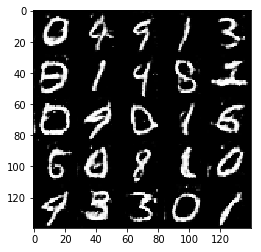

Epoch 2/2... Discriminator Loss: 1.4919... Generator Loss: 3.7203
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.4361
Epoch 2/2... Discriminator Loss: 0.6346... Generator Loss: 1.3063
Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 0.6935... Generator Loss: 1.1289
Epoch 2/2... Discriminator Loss: 2.6602... Generator Loss: 0.1299
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.0311
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 0.6046
Epoch 2/2... Discriminator Loss: 0.6407... Generator Loss: 1.1536


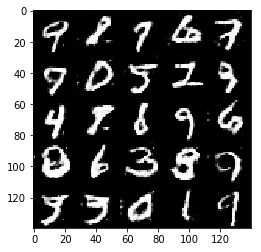

Epoch 2/2... Discriminator Loss: 0.6405... Generator Loss: 1.1923
Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 0.6772... Generator Loss: 0.8829
Epoch 2/2... Discriminator Loss: 1.8994... Generator Loss: 0.2971
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 0.7585
Epoch 2/2... Discriminator Loss: 1.1602... Generator Loss: 0.5605
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 0.5466
Epoch 2/2... Discriminator Loss: 0.4915... Generator Loss: 1.2416
Epoch 2/2... Discriminator Loss: 0.5213... Generator Loss: 1.4157
Epoch 2/2... Discriminator Loss: 1.9838... Generator Loss: 0.2569


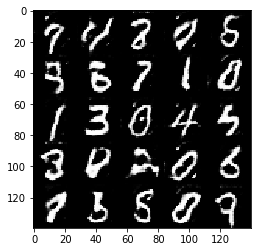

Epoch 2/2... Discriminator Loss: 0.6179... Generator Loss: 1.3713
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 1.5538
Epoch 2/2... Discriminator Loss: 0.7246... Generator Loss: 1.0106
Epoch 2/2... Discriminator Loss: 0.9193... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 3.4055... Generator Loss: 5.4652
Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 1.4171
Epoch 2/2... Discriminator Loss: 0.7097... Generator Loss: 1.4310
Epoch 2/2... Discriminator Loss: 0.8820... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 2.2498... Generator Loss: 0.1546
Epoch 2/2... Discriminator Loss: 0.8451... Generator Loss: 1.1686


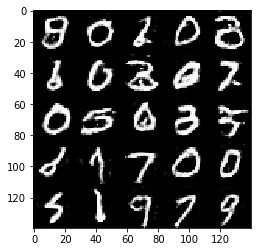

Epoch 2/2... Discriminator Loss: 0.7501... Generator Loss: 2.3286
Epoch 2/2... Discriminator Loss: 1.1903... Generator Loss: 0.5441
Epoch 2/2... Discriminator Loss: 0.6254... Generator Loss: 0.9760
Epoch 2/2... Discriminator Loss: 1.8034... Generator Loss: 0.2380
Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.4607
Epoch 2/2... Discriminator Loss: 1.7654... Generator Loss: 0.2517
Epoch 2/2... Discriminator Loss: 0.7746... Generator Loss: 0.9489
Epoch 2/2... Discriminator Loss: 0.8668... Generator Loss: 1.0082
Epoch 2/2... Discriminator Loss: 0.7443... Generator Loss: 1.4572


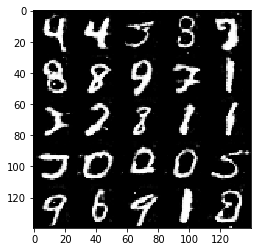

Epoch 2/2... Discriminator Loss: 1.7325... Generator Loss: 0.2935
Epoch 2/2... Discriminator Loss: 1.5285... Generator Loss: 0.3934
Epoch 2/2... Discriminator Loss: 0.5374... Generator Loss: 1.2447
Epoch 2/2... Discriminator Loss: 0.5942... Generator Loss: 1.0972
Epoch 2/2... Discriminator Loss: 0.4235... Generator Loss: 1.6965
Epoch 2/2... Discriminator Loss: 0.5806... Generator Loss: 1.1476
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 4.0755
Epoch 2/2... Discriminator Loss: 1.5649... Generator Loss: 0.3694
Epoch 2/2... Discriminator Loss: 0.5535... Generator Loss: 1.2864
Epoch 2/2... Discriminator Loss: 0.5597... Generator Loss: 1.2312


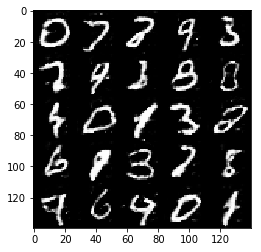

Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 2.9414
Epoch 2/2... Discriminator Loss: 0.5088... Generator Loss: 1.3231
Epoch 2/2... Discriminator Loss: 0.3838... Generator Loss: 1.6022
Epoch 2/2... Discriminator Loss: 2.9180... Generator Loss: 5.1459
Epoch 2/2... Discriminator Loss: 0.7180... Generator Loss: 1.6220
Epoch 2/2... Discriminator Loss: 0.8765... Generator Loss: 2.5355
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 2.5355
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.5264
Epoch 2/2... Discriminator Loss: 1.4149... Generator Loss: 0.5140
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 0.9165


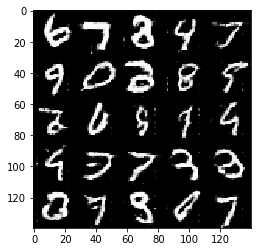

Epoch 2/2... Discriminator Loss: 0.7098... Generator Loss: 0.9009
Epoch 2/2... Discriminator Loss: 0.8058... Generator Loss: 0.7422
Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 2.5400... Generator Loss: 0.1182
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 0.5888
Epoch 2/2... Discriminator Loss: 1.1094... Generator Loss: 0.6399
Epoch 2/2... Discriminator Loss: 0.6121... Generator Loss: 1.6422
Epoch 2/2... Discriminator Loss: 0.7773... Generator Loss: 1.2750
Epoch 2/2... Discriminator Loss: 1.4691... Generator Loss: 0.5114
Epoch 2/2... Discriminator Loss: 0.7939... Generator Loss: 1.8209


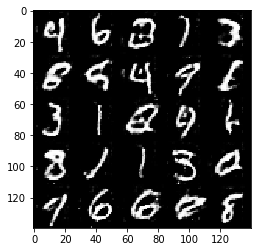

Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 0.9266
Epoch 2/2... Discriminator Loss: 0.4963... Generator Loss: 1.4668
Epoch 2/2... Discriminator Loss: 0.4157... Generator Loss: 1.6733
Epoch 2/2... Discriminator Loss: 0.6040... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 0.6710... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 0.5760... Generator Loss: 1.3092
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 0.9187
Epoch 2/2... Discriminator Loss: 0.4414... Generator Loss: 1.7655
Epoch 2/2... Discriminator Loss: 0.7004... Generator Loss: 1.1083
Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 0.6787


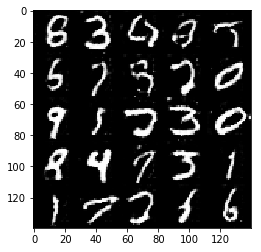

Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.1919... Generator Loss: 2.7145
Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.4409
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 1.1326
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 0.5106
Epoch 2/2... Discriminator Loss: 0.5444... Generator Loss: 1.0899
Epoch 2/2... Discriminator Loss: 0.6806... Generator Loss: 1.0294
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 1.1185
Epoch 2/2... Discriminator Loss: 0.4655... Generator Loss: 1.5467
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.4729


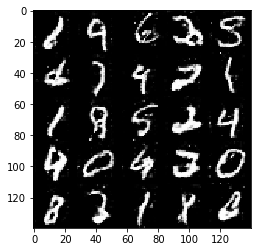

Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 3.9222
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 2.4215
Epoch 2/2... Discriminator Loss: 1.0309... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 2.3874... Generator Loss: 0.1479
Epoch 2/2... Discriminator Loss: 0.5331... Generator Loss: 1.2721
Epoch 2/2... Discriminator Loss: 0.4773... Generator Loss: 1.3193
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 0.5520... Generator Loss: 1.4703
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.5658
Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 0.8920


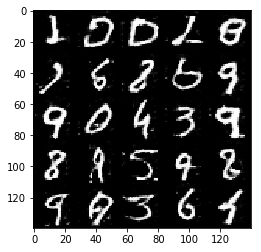

Epoch 2/2... Discriminator Loss: 0.8696... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 0.6511... Generator Loss: 2.3274
Epoch 2/2... Discriminator Loss: 0.5227... Generator Loss: 2.0153
Epoch 2/2... Discriminator Loss: 1.1419... Generator Loss: 0.7640
Epoch 2/2... Discriminator Loss: 0.7964... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 0.5682
Epoch 2/2... Discriminator Loss: 0.7360... Generator Loss: 0.9255
Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 0.6435
Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 1.0084
Epoch 2/2... Discriminator Loss: 1.7824... Generator Loss: 0.3564


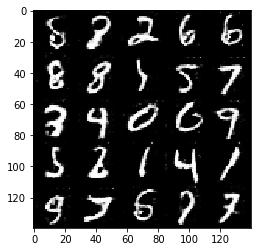

In [29]:
batch_size = 40
z_dim = 30
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.9685... Generator Loss: 0.0112
Epoch 1/1... Discriminator Loss: 4.9126... Generator Loss: 0.0149
Epoch 1/1... Discriminator Loss: 4.7802... Generator Loss: 0.0253
Epoch 1/1... Discriminator Loss: 3.7200... Generator Loss: 0.0749
Epoch 1/1... Discriminator Loss: 3.1270... Generator Loss: 0.1319
Epoch 1/1... Discriminator Loss: 2.4800... Generator Loss: 0.2799
Epoch 1/1... Discriminator Loss: 1.9452... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.6734... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7825


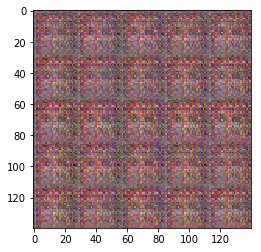

Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.9915


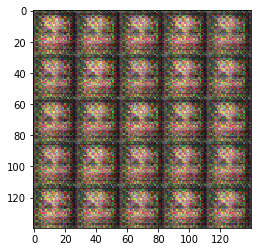

Epoch 1/1... Discriminator Loss: 0.7280... Generator Loss: 1.2036
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.4768
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.1948
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.3998
Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 1.5620
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 1.4203


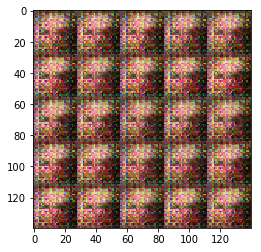

Epoch 1/1... Discriminator Loss: 0.5663... Generator Loss: 1.5704
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 1.7830
Epoch 1/1... Discriminator Loss: 0.4035... Generator Loss: 1.8029
Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 1.6277
Epoch 1/1... Discriminator Loss: 0.2829... Generator Loss: 1.7403
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 1.4362
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 1.8111
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 1.6259


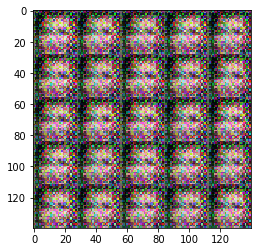

Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 1.4005
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 1.5473
Epoch 1/1... Discriminator Loss: 0.6936... Generator Loss: 1.5038
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 1.5734
Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 1.6903
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.3618
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 1.6136
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 1.8790
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 1.7011


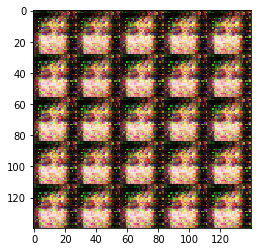

Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.3664
Epoch 1/1... Discriminator Loss: 0.3097... Generator Loss: 1.9685
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 1.8377
Epoch 1/1... Discriminator Loss: 0.4555... Generator Loss: 1.9327
Epoch 1/1... Discriminator Loss: 0.2388... Generator Loss: 2.1016
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 1.7119
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 1.9772
Epoch 1/1... Discriminator Loss: 0.5372... Generator Loss: 1.6025
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 1.6657
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 1.6254


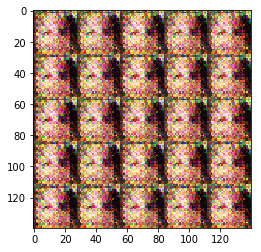

Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.4010
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 1.7867
Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 1.8261
Epoch 1/1... Discriminator Loss: 0.3009... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 0.3263... Generator Loss: 2.0928
Epoch 1/1... Discriminator Loss: 0.4822... Generator Loss: 1.5899
Epoch 1/1... Discriminator Loss: 0.2916... Generator Loss: 2.2700
Epoch 1/1... Discriminator Loss: 0.2236... Generator Loss: 2.1636
Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 1.7231
Epoch 1/1... Discriminator Loss: 0.3271... Generator Loss: 1.8802


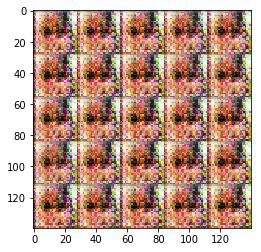

Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 1.7826
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 1.8777
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 1.7367
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 2.0572
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 1.7752
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 1.4568
Epoch 1/1... Discriminator Loss: 0.2700... Generator Loss: 2.0176
Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 1.9237
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 1.6480
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 1.9032


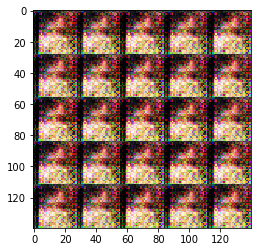

Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 2.0353
Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 1.6967
Epoch 1/1... Discriminator Loss: 0.3029... Generator Loss: 2.2492
Epoch 1/1... Discriminator Loss: 0.2027... Generator Loss: 2.4199
Epoch 1/1... Discriminator Loss: 0.1451... Generator Loss: 2.4698
Epoch 1/1... Discriminator Loss: 0.2319... Generator Loss: 2.3030
Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 1.9928
Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 2.0535
Epoch 1/1... Discriminator Loss: 0.3037... Generator Loss: 2.3146
Epoch 1/1... Discriminator Loss: 0.2183... Generator Loss: 2.3830


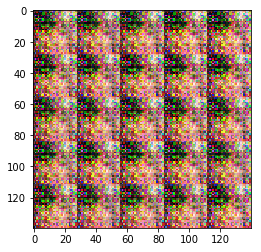

Epoch 1/1... Discriminator Loss: 0.2727... Generator Loss: 2.1663
Epoch 1/1... Discriminator Loss: 0.1623... Generator Loss: 2.2424
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 1.4753
Epoch 1/1... Discriminator Loss: 0.3417... Generator Loss: 2.1051
Epoch 1/1... Discriminator Loss: 0.3450... Generator Loss: 2.0279
Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 2.5283
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 1.9772
Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 1.8882
Epoch 1/1... Discriminator Loss: 0.1761... Generator Loss: 2.6279
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 1.7615


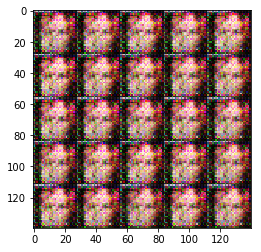

Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 1.7919
Epoch 1/1... Discriminator Loss: 0.2727... Generator Loss: 2.0602
Epoch 1/1... Discriminator Loss: 0.2613... Generator Loss: 2.4625
Epoch 1/1... Discriminator Loss: 0.1233... Generator Loss: 3.1036
Epoch 1/1... Discriminator Loss: 0.2485... Generator Loss: 2.6008
Epoch 1/1... Discriminator Loss: 0.2619... Generator Loss: 2.2599
Epoch 1/1... Discriminator Loss: 0.2530... Generator Loss: 2.0691
Epoch 1/1... Discriminator Loss: 0.1569... Generator Loss: 2.5161
Epoch 1/1... Discriminator Loss: 0.1369... Generator Loss: 2.6670
Epoch 1/1... Discriminator Loss: 0.2314... Generator Loss: 2.3246


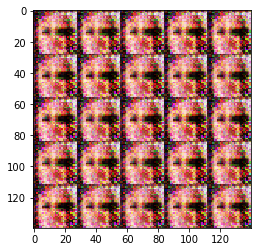

Epoch 1/1... Discriminator Loss: 0.1892... Generator Loss: 2.3956
Epoch 1/1... Discriminator Loss: 0.1163... Generator Loss: 2.5665
Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 2.6357
Epoch 1/1... Discriminator Loss: 0.1886... Generator Loss: 2.4527
Epoch 1/1... Discriminator Loss: 0.2668... Generator Loss: 2.3402
Epoch 1/1... Discriminator Loss: 0.3194... Generator Loss: 2.1560
Epoch 1/1... Discriminator Loss: 0.1722... Generator Loss: 2.7878
Epoch 1/1... Discriminator Loss: 0.2528... Generator Loss: 2.1910
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 1.7926
Epoch 1/1... Discriminator Loss: 0.3102... Generator Loss: 2.2437


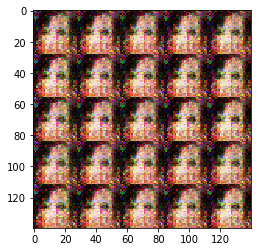

Epoch 1/1... Discriminator Loss: 0.2234... Generator Loss: 2.7434
Epoch 1/1... Discriminator Loss: 0.2816... Generator Loss: 2.0722
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 1.5318
Epoch 1/1... Discriminator Loss: 0.1979... Generator Loss: 2.4372
Epoch 1/1... Discriminator Loss: 0.1348... Generator Loss: 2.8848
Epoch 1/1... Discriminator Loss: 0.2121... Generator Loss: 2.2757
Epoch 1/1... Discriminator Loss: 0.2487... Generator Loss: 2.2836
Epoch 1/1... Discriminator Loss: 0.2899... Generator Loss: 1.9040
Epoch 1/1... Discriminator Loss: 0.0942... Generator Loss: 2.9858
Epoch 1/1... Discriminator Loss: 0.2537... Generator Loss: 2.3825


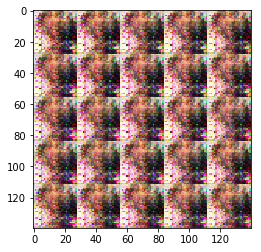

Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 2.0962
Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 1.8788
Epoch 1/1... Discriminator Loss: 0.2634... Generator Loss: 2.1764
Epoch 1/1... Discriminator Loss: 0.1166... Generator Loss: 2.7767
Epoch 1/1... Discriminator Loss: 0.2186... Generator Loss: 2.4705
Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 2.4737
Epoch 1/1... Discriminator Loss: 0.1383... Generator Loss: 2.7612
Epoch 1/1... Discriminator Loss: 0.1666... Generator Loss: 2.7349
Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 1.8700
Epoch 1/1... Discriminator Loss: 0.3823... Generator Loss: 2.1396


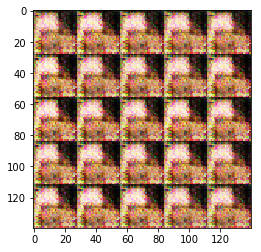

Epoch 1/1... Discriminator Loss: 0.3168... Generator Loss: 2.2309
Epoch 1/1... Discriminator Loss: 0.2750... Generator Loss: 2.4538
Epoch 1/1... Discriminator Loss: 0.1777... Generator Loss: 2.4891
Epoch 1/1... Discriminator Loss: 0.3365... Generator Loss: 2.1396
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 1.8879
Epoch 1/1... Discriminator Loss: 0.1448... Generator Loss: 2.8335
Epoch 1/1... Discriminator Loss: 0.1035... Generator Loss: 3.0456
Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 3.1193
Epoch 1/1... Discriminator Loss: 0.1101... Generator Loss: 2.8944
Epoch 1/1... Discriminator Loss: 0.1865... Generator Loss: 2.7629


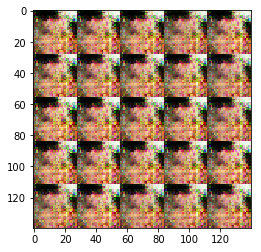

Epoch 1/1... Discriminator Loss: 0.3139... Generator Loss: 2.3975
Epoch 1/1... Discriminator Loss: 0.1637... Generator Loss: 2.8234
Epoch 1/1... Discriminator Loss: 0.1920... Generator Loss: 3.1011
Epoch 1/1... Discriminator Loss: 0.2326... Generator Loss: 2.4819
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 2.2256
Epoch 1/1... Discriminator Loss: 0.1921... Generator Loss: 2.5095
Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 3.1016
Epoch 1/1... Discriminator Loss: 0.3004... Generator Loss: 2.2203
Epoch 1/1... Discriminator Loss: 0.2823... Generator Loss: 2.5969
Epoch 1/1... Discriminator Loss: 0.2959... Generator Loss: 2.3787


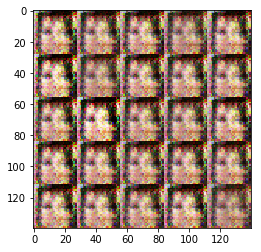

Epoch 1/1... Discriminator Loss: 0.2450... Generator Loss: 2.3043
Epoch 1/1... Discriminator Loss: 0.1284... Generator Loss: 2.7259
Epoch 1/1... Discriminator Loss: 0.1943... Generator Loss: 2.3705
Epoch 1/1... Discriminator Loss: 0.1579... Generator Loss: 2.7338
Epoch 1/1... Discriminator Loss: 0.2772... Generator Loss: 2.6335
Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 1.8634
Epoch 1/1... Discriminator Loss: 0.5590... Generator Loss: 2.0231
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 1.7526


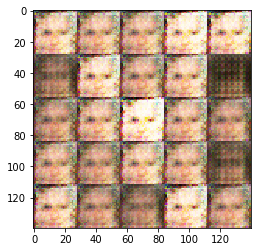

Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 1.3101
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.7005
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.7600


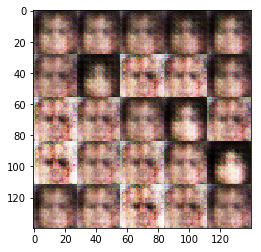

Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.3273
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.5453
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.3673
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.8492


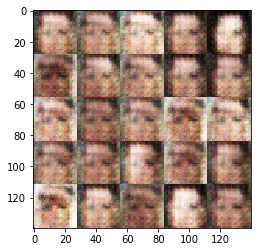

Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.2819
Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.1603
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8584


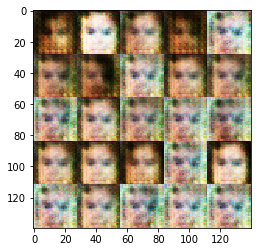

Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 1.1328
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.2877
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.9279


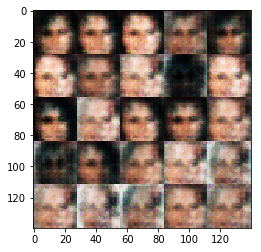

Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 1.2856
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.1744


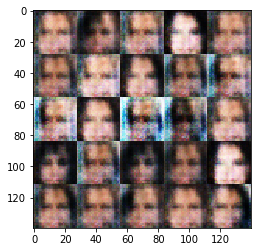

Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.1080
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 1.0205


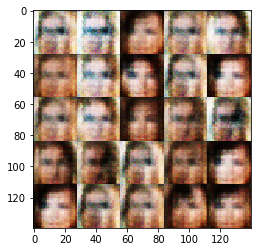

Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.1040


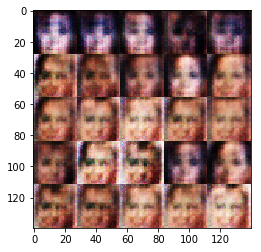

Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.2822
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 1.2538
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.0264


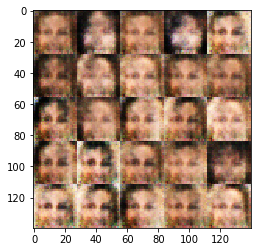

Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.9817


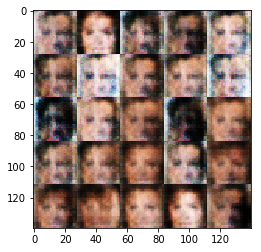

Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.9592


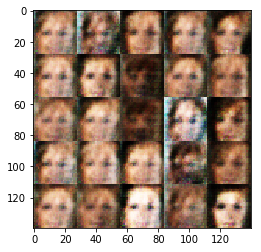

Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.9260


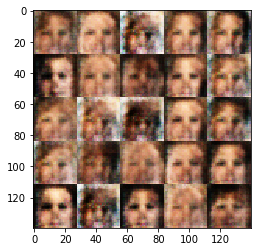

Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.2138
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.8580


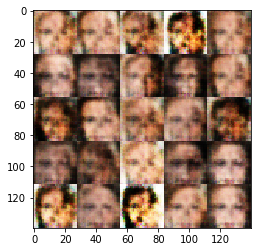

Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8885


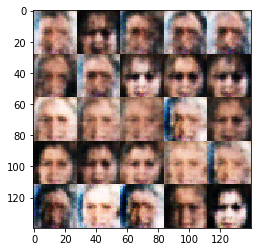

Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.6520


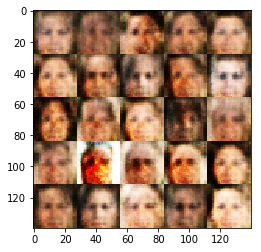

Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 1.2569
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.8017


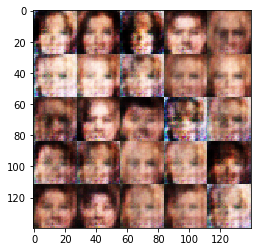

Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.6530... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.0591


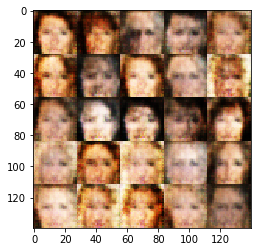

Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 1.0213


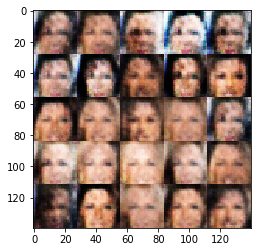

Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7620


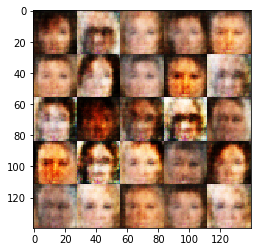

Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.8001


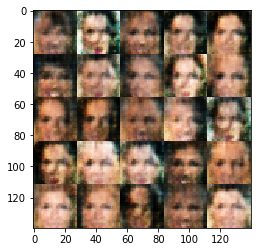

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.6950


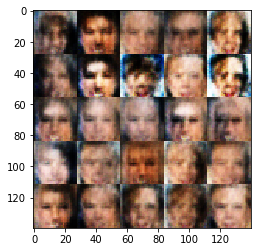

Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7281


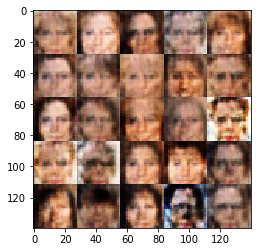

Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.9782


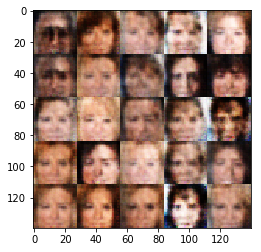

Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7915


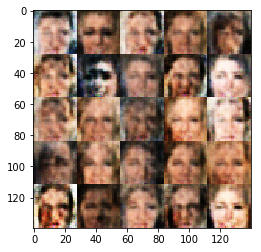

Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8802


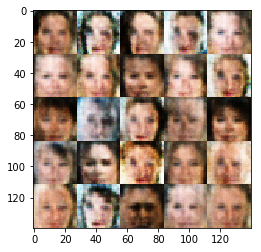

Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.9452


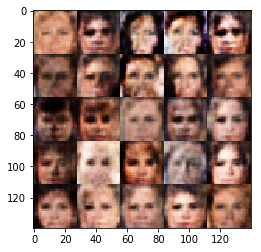

Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.8695


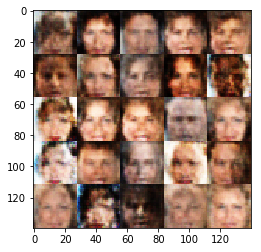

Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8050


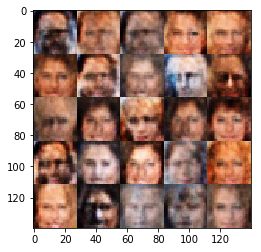

Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8011


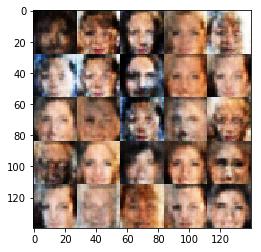

Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.1843
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8247


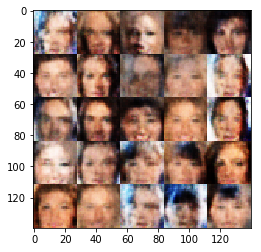

Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.7567


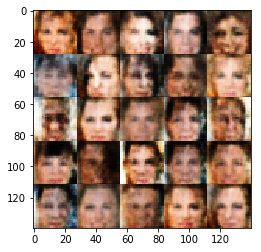

Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7273


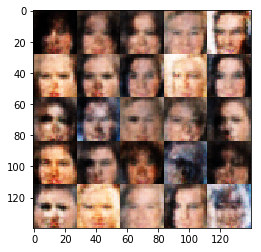

Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.8924


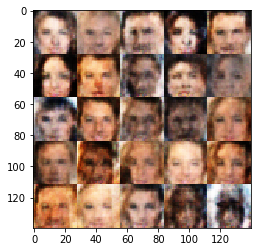

Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7057


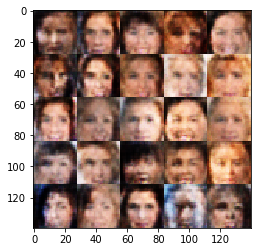

Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7677


In [30]:
batch_size = 40
z_dim = 50
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.